In [1]:
# Deal with the imports and invoke pip if necessary
import torch
try:
  from transformers import (AutoTokenizer, BertConfig,
                            BertForSequenceClassification,
                            BertTokenizer, BertPreTrainedModel,
                            AdamW)
except:
  !pip install transformers
  from transformers import (AutoTokenizer, BertConfig,
                            BertForSequenceClassification,
                            BertTokenizer, BertPreTrainedModel,
                            AdamW)

import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Ignore UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Run the model on GPU whenever possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0)}")

# Initialize RNG's to ensure consistency between runs
random.seed(321)
np.random.seed(321)
torch.manual_seed(321)

# Mount the drive where test.csv and train.csv live
from google.colab import drive
drive.mount('/content/drive')

# Load the files from drive, but use a fraction of the training data so as to
# not overload Colab's GPU RAM
train_df = pd.read_csv(r'/content/drive/MyDrive/train.csv')
test_df = pd.read_csv(r'/content/drive/MyDrive/test.csv')
train_df = train_df[:1500]
test_df = test_df[:500]

# Extract texts and labels from Pandas dataframes
train_texts = train_df['text'].tolist()
train_labels = train_df['sentiment'].map({'neg': 0, 'pos': 1}).tolist()
test_texts = test_df['text'].tolist()
test_labels = test_df['sentiment'].map({'neg': 0, 'pos': 1}).tolist()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 18.6 MB/s eta 0:00:00
Using device: Tesla T4
Mounted at /content/drive


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [2]:
def preprocess(texts, labels, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    # For each sentence...
    for text in texts:
        # Encode the text and add `[CLS]` and `[SEP]` tokens.
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Add the encoded sentence to the list of input_ids
        input_ids.append(encoded['input_ids'])

        # Add its attention mask (differentiates padding from non-padding) to the list of attention_masks
        attention_masks.append(encoded['attention_mask'])

    # Convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    labels = torch.tensor(labels).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return (dataset, attention_masks, input_ids)

In [5]:
(train_data, train_attention_masks,
 train_input_ids) = preprocess(train_texts, train_labels, tokenizer, 512)
(test_data, test_attention_masks,
 test_input_ids) = preprocess(test_texts, test_labels, tokenizer, 512)

In [26]:
epochs = 5
batch_size = 3
learning_rate = 3e-6

In [27]:
  # Load the pre-trained BERT model for sequence classification
  model = BertForSequenceClassification.from_pretrained(
  'bert-base-uncased', 
  num_labels = 2, # Binary classification task
  output_attentions = True, # to display self-attention matrix 
  output_hidden_states = False,
  )

  # Make sure it works on GPU whenever it's available
  model.to(device)

  # Set up the optimizer and learning rate scheduler
  optimizer = AdamW(model.parameters(), lr = learning_rate)
  total_steps = len(train_data) * epochs

  # Set up the data loader for training and testing data
  train_dataloader = DataLoader(train_data, 
                                sampler = RandomSampler(train_data), 
                                batch_size = batch_size)
  test_dataloader = DataLoader(test_data, 
                              sampler = SequentialSampler(test_data), 
                              batch_size = batch_size)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [28]:
for epoch in range(epochs):
      # ======== Training ======== #
      # Set the model to training mode
      model.train()

      # Initialize variables to track training loss and accuracy
      train_loss = 0.0
      train_accuracy = 0.0
      train_precision = 0.0
      train_recall = 0.0
      train_f1 = 0.0
      num_train_steps = 0

      # Loop through each batch in the training dataloader
      print(f"Training underway for epoch {epoch}...")
      for batch in train_dataloader:
          # Unpack the batch from dataloader
          batch_input_ids = batch[0].to(device)
          batch_attention_masks = batch[1].to(device)
          batch_labels = batch[2].to(device)

          # Clear gradients
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch)
          model_output = model(input_ids=batch_input_ids, 
                              attention_mask=batch_attention_masks, 
                              labels=batch_labels)

          # The outputs of the model are a tuple of (loss, logits, hidden_states, attentions)
          # We only need the loss and logits to calculate accuracy
          loss = model_output.loss
          logits = model_output.logits

          # Backward pass to calculate gradients
          loss.backward()

          # Update parameters and take a step using the computed gradient
          optimizer.step()

          # Update variables to track training loss and accuracy
          train_loss += loss.item()
          train_accuracy += accuracy_score(batch_labels.cpu(),
                                           logits.argmax(axis=1).cpu())
          train_precision += precision_score(batch_labels.cpu(),
                                             logits.argmax(axis=1).cpu(),
                                             average='weighted')
          train_recall += recall_score(batch_labels.cpu(),
                                       logits.argmax(axis=1).cpu(),
                                       average='weighted')
          train_f1 += f1_score(batch_labels.cpu(),
                               logits.argmax(axis=1).cpu(),
                               average='weighted')
          num_train_steps += 1

      # Calculate the average training loss and accuracy for this epoch
      avg_train_loss = train_loss / num_train_steps
      avg_train_accuracy = train_accuracy / num_train_steps
      avg_train_precision = train_precision / num_train_steps
      avg_train_recall = train_recall / num_train_steps
      avg_train_f1 = train_f1 / num_train_steps

      # ======== Validation ======== #
      # Set the model to evaluation mode
      model.eval()

      # Initialize variables to track validation loss and accuracy
      test_loss = 0.0
      test_accuracy = 0.0
      test_precision = 0.0
      test_recall = 0.0
      test_f1 = 0.0

      num_test_steps = 0

      # Loop through each batch in the validation dataloader
      for batch in test_dataloader:
          # Unpack the batch from dataloader
          batch_input_ids = batch[0].to(device)
          batch_attention_masks = batch[1].to(device)
          batch_labels = batch[2].to(device)

          # Disable gradient calculations to save memory and computation
          with torch.no_grad():
              # Perform a forward pass (evaluate the model on this validation batch)
              model_output = model(input_ids=batch_input_ids, 
                                  attention_mask=batch_attention_masks, 
                                  labels=batch_labels)

              # The outputs of the model are a tuple of (loss, logits, hidden_states, attentions)
              # We only need the loss and logits to calculate accuracy
              loss = model_output.loss
              logits = model_output.logits

              # Update variables to track training loss and accuracy
              test_loss += loss.item()
              test_accuracy += accuracy_score(batch_labels.cpu(),
                                               logits.argmax(axis=1).cpu())
              test_precision += precision_score(batch_labels.cpu(),
                                                 logits.argmax(axis=1).cpu(),
                                                 average='weighted')
              test_recall += recall_score(batch_labels.cpu(),
                                           logits.argmax(axis=1).cpu(),
                                           average='weighted')
              test_f1 += f1_score(batch_labels.cpu(),
                                   logits.argmax(axis=1).cpu(),
                                   average='weighted')
              num_test_steps += 1

      # Calculate the average training loss and accuracy for this epoch
      avg_test_loss = test_loss / num_test_steps
      avg_test_accuracy = test_accuracy / num_test_steps
      avg_test_precision = test_precision / num_test_steps
      avg_test_recall = test_recall / num_test_steps
      avg_test_f1 = test_f1 / num_test_steps

      # Output an epoch-by-epoch report
      print(f"Epoch {epoch} __________________________________________________")
      print(f"Train loss: {round(avg_train_loss, 3)}, Train accuracy: {round(avg_train_accuracy, 3)}")
      print(f"Train precision: {round(avg_train_precision, 3)}, Train recall: {round(avg_train_recall, 3)}")
      print(f"Train F1 score: {round(avg_train_f1, 3)}, Train accuracy: {round(avg_train_f1, 3)}")
      print()
      print(f"Test loss: {round(avg_test_loss, 3)}, Test accuracy: {round(avg_test_accuracy, 3)}")
      print(f"Test precision: {round(avg_test_precision, 3)}, Test recall: {round(avg_test_recall, 3)}")
      print(f"Test F1 score: {round(avg_test_f1, 3)}, Test accuracy: {round(avg_test_f1, 3)}")
      print("\n\n")

Training underway for epoch 0...
Epoch 0 __________________________________________________
Train loss: 0.529, Train accuracy: 0.763
Train precision: 0.779, Train recall: 0.763
Train F1 score: 0.744, Train accuracy: 0.744

Test loss: 0.359, Test accuracy: 0.862
Test precision: 0.888, Test recall: 0.862
Test F1 score: 0.854, Test accuracy: 0.854



Training underway for epoch 1...
Epoch 1 __________________________________________________
Train loss: 0.272, Train accuracy: 0.895
Train precision: 0.925, Train recall: 0.895
Train F1 score: 0.895, Train accuracy: 0.895

Test loss: 0.263, Test accuracy: 0.906
Test precision: 0.934, Test recall: 0.906
Test F1 score: 0.904, Test accuracy: 0.904



Training underway for epoch 2...
Epoch 2 __________________________________________________
Train loss: 0.15, Train accuracy: 0.953
Train precision: 0.97, Train recall: 0.953
Train F1 score: 0.954, Train accuracy: 0.954

Test loss: 0.243, Test accuracy: 0.914
Test precision: 0.939, Test recall: 0.91

In [29]:
misclassified = []
y_true = []
y_pred = []

# Set the model to evaluation mode
model.eval()

# Create a test dataloader
test_dataloader = DataLoader(test_data, 
                          sampler = SequentialSampler(test_data), 
                          batch_size = batch_size)

# Loop through each batch in the test dataloader
for batch in test_dataloader:
  # Unpack the batch from dataloader
  batch_input_ids = batch[0].to(device)
  batch_attention_masks = batch[1].to(device)
  batch_labels = batch[2].to(device)

  # Disable gradient calculations to save memory and computation
  with torch.no_grad():
      # Perform a forward pass (evaluate the model on this validation batch)
      model_output = model(input_ids=batch_input_ids, 
                            attention_mask=batch_attention_masks, 
                            labels=batch_labels)

      # The outputs of the model are a tuple of (loss, logits, hidden_states, attentions)
      # We only need the logits to calculate accuracy
      logits = model_output.logits

      # Get the predicted labels by taking the argmax of the logits
      predicted_labels = logits.argmax(axis=1)

      # Get the misclassified sentences by comparing the predicted labels with the true labels
      for i in range(len(batch_labels)):
          y_true.append(batch_labels[i].item())
          y_pred.append(predicted_labels[i].item())
          if predicted_labels[i] != batch_labels[i]:
              input_ids = batch_input_ids[i].detach().cpu().numpy()
              misclassified.append((input_ids, predicted_labels[i].item(),
                                    batch_labels[i].item(),
                                    model_output.attentions[-1][i].detach().cpu().numpy()))



              precision    recall  f1-score   support

    negative       0.91      0.94      0.92       246
    positive       0.94      0.91      0.92       254

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



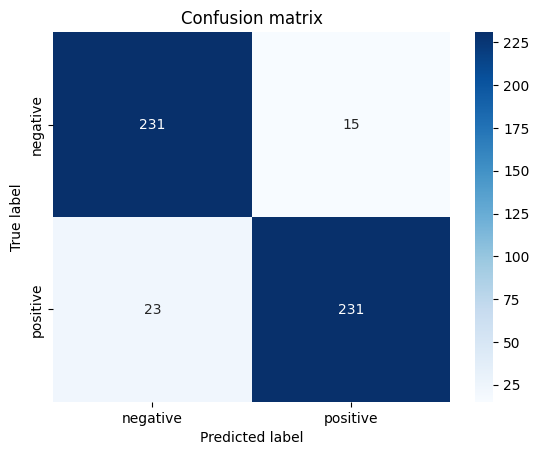

In [30]:
misclassified = []

# Set the model to evaluation mode
model.eval()

# Create a test dataloader
test_dataloader = DataLoader(test_data, 
                          sampler = SequentialSampler(test_data), 
                          batch_size = batch_size)

# Initialize empty lists to store true labels and predicted labels
y_true = []
y_pred = []

# Loop through each batch in the test dataloader
for batch in test_dataloader:
    # Unpack the batch from dataloader
    batch_input_ids = batch[0].to(device)
    batch_attention_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)

    # Disable gradient calculations to save memory and computation
    with torch.no_grad():
        # Perform a forward pass (evaluate the model on this validation batch)
        model_output = model(input_ids=batch_input_ids, 
                             attention_mask=batch_attention_masks, 
                             labels=batch_labels)

        # The outputs of the model are a tuple of (loss, logits, hidden_states, attentions)
        # We only need the logits to calculate accuracy
        logits = model_output.logits

        # Get the predicted labels by taking the argmax of the logits
        predicted_labels = logits.argmax(axis=1)

        # Store the true labels and predicted labels for later use
        y_true.extend(batch_labels.cpu().numpy())
        y_pred.extend(predicted_labels.cpu().numpy())

        # Get the misclassified sentences by comparing the predicted labels with the true labels
        for i in range(len(batch_labels)):
            if predicted_labels[i] != batch_labels[i]:
                input_ids = batch_input_ids[i].detach().cpu().numpy()
                misclassified.append((input_ids, predicted_labels[i].item(),
                                      batch_labels[i].item(),
                                      model_output.attentions[-1][i].detach().cpu().numpy()))

# Print classification report
target_names = ['negative', 'positive'] 
print(classification_report(y_true, y_pred, target_names=target_names))

# Print confusion matrix
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [14]:
  sentence_idx = 2

  decoded_sentence = tokenizer.decode(misclassified[sentence_idx][0], skip_special_tokens=True)

  print(decoded_sentence)
  print(f"Predicted label: {misclassified[sentence_idx][2]}, Actual label: {misclassified[sentence_idx][1]}")
  attention = misclassified[sentence_idx][3]
  print(attention.shape)


  tokens = decoded_sentence.split()
  plt.figure(figsize=(len(tokens), len(tokens)))
  # Find the position of the [PAD] token in the input sequence
  pad_token_pos = np.where(input_ids == tokenizer.pad_token_id)[0][0]

  plt.imshow(attention[-1][:len(tokens), :len(tokens)], cmap='hot', interpolation='nearest')
  plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=62)
  plt.yticks(range(len(tokens)), tokens, fontsize=62)
  plt.colorbar()
  plt.grid(True)
  plt.xlabel('Input Tokens')
  plt.ylabel('Output Tokens')
  plt.show()

if you want to see a film starring stan laurel from the laurel & hardy comedies, this is not the film for you. stan would not begin to find the character and rhythms of those films for another two years. if, however, you want a good travesty of the rudolph valentino blood and sand, which had been made the previous year, this is the movie for you. all the stops are pulled out, both in physical comedy and on the title cards and if the movie is not held together by character, the plot of valentino's movie is used - - well sort of.
Predicted label: 1, Actual label: 0
(12, 512, 512)


not a film of entertainment, but of real lives & limited ambition for the working class in 60's. enjoyable because of my upbringing, not sure it'd work for most people. typical loach. full of tv actors / actresses of 70's / 80's / 90's.
Predicted label: 1, Actual label: 0
(12, 512, 512)


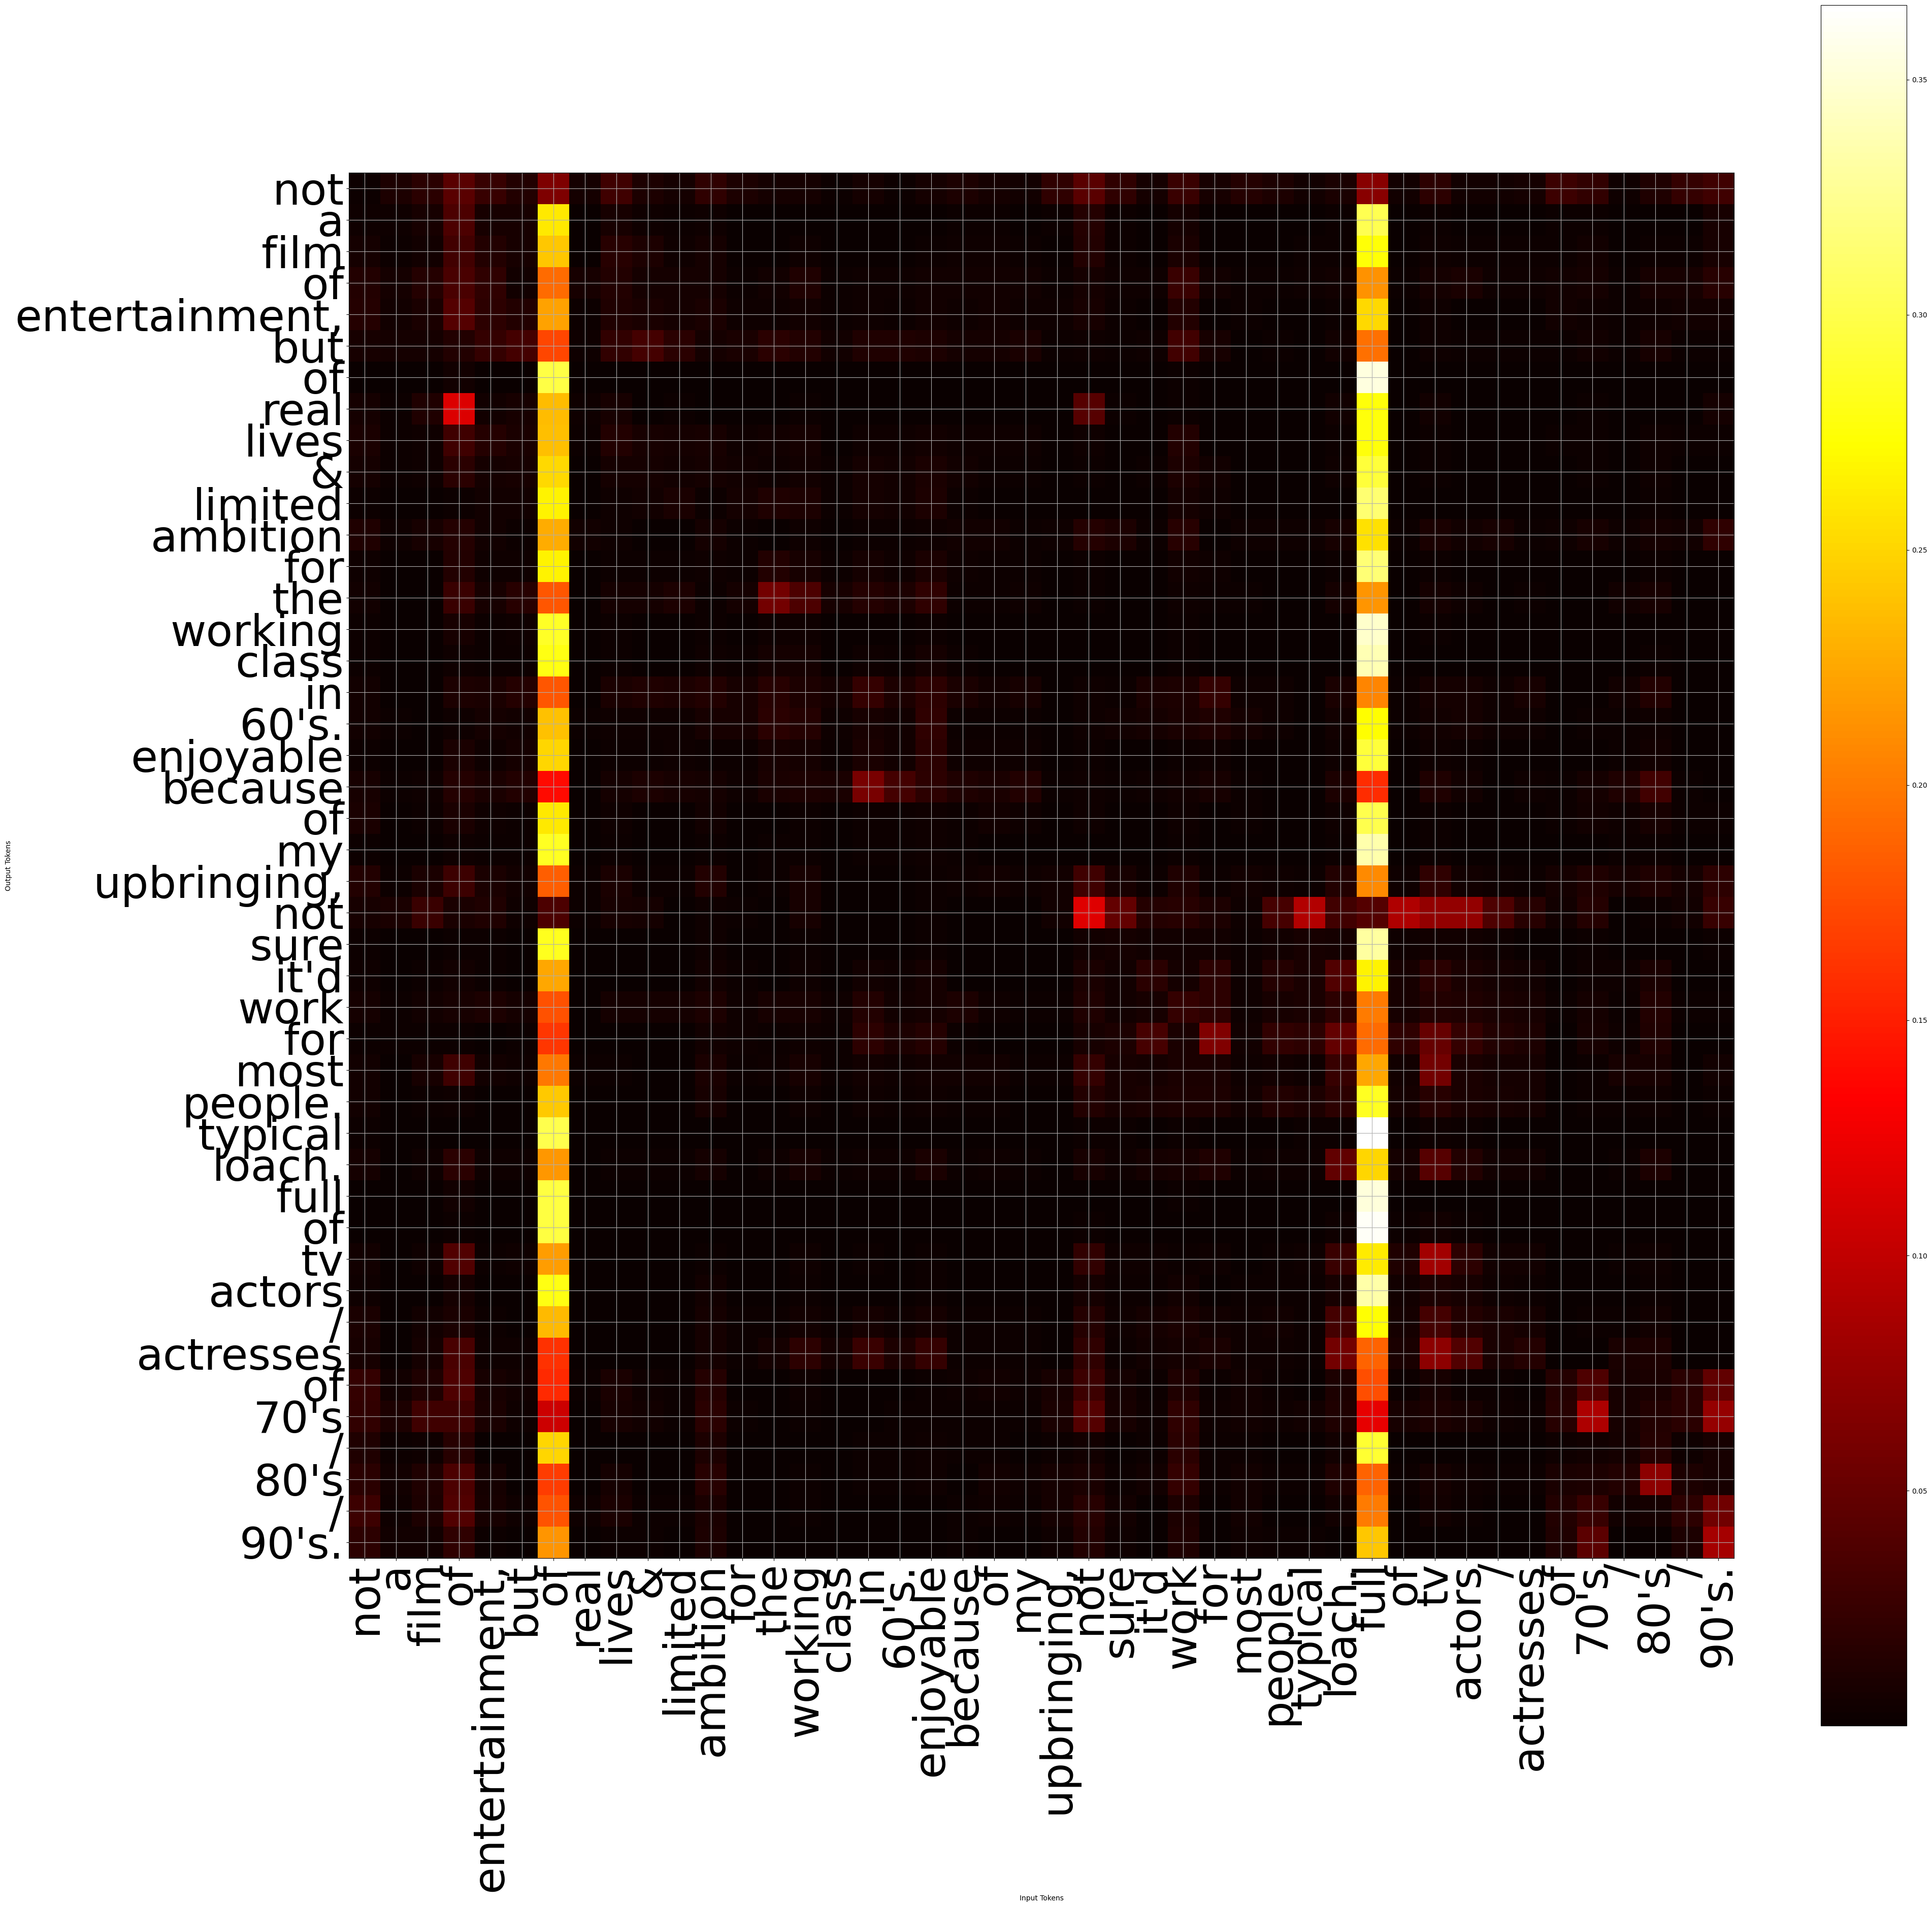

In [31]:
  sentence_idx = 5

  decoded_sentence = tokenizer.decode(misclassified[sentence_idx][0], skip_special_tokens=True)

  print(decoded_sentence)
  print(f"Predicted label: {misclassified[sentence_idx][2]}, Actual label: {misclassified[sentence_idx][1]}")
  attention = misclassified[sentence_idx][3]
  print(attention.shape)


  tokens = decoded_sentence.split()
  plt.figure(figsize=(len(tokens), len(tokens)))
  # Find the position of the [PAD] token in the input sequence
  pad_token_pos = np.where(input_ids == tokenizer.pad_token_id)[0][0]

  plt.imshow(attention[-1][:len(tokens), :len(tokens)], cmap='hot', interpolation='nearest')
  plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=62)
  plt.yticks(range(len(tokens)), tokens, fontsize=62)
  plt.colorbar()
  plt.grid(True)
  plt.xlabel('Input Tokens')
  plt.ylabel('Output Tokens')
  plt.show()

In [34]:
  sentence_idx = 15

  decoded_sentence = tokenizer.decode(misclassified[sentence_idx][0], skip_special_tokens=True)

  print(decoded_sentence)
  print(f"Predicted label: {misclassified[sentence_idx][2]}, Actual label: {misclassified[sentence_idx][1]}")
  attention = misclassified[sentence_idx][3]
  print(attention.shape)


  tokens = decoded_sentence.split()
  plt.figure(figsize=(len(tokens), len(tokens)))
  # Find the position of the [PAD] token in the input sequence
  pad_token_pos = np.where(input_ids == tokenizer.pad_token_id)[0][0]

  plt.imshow(attention[-1][:len(tokens), :len(tokens)], cmap='hot', interpolation='nearest')
  plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=62)
  plt.yticks(range(len(tokens)), tokens, fontsize=62)
  plt.colorbar()
  plt.grid(True)
  plt.xlabel('Input Tokens')
  plt.ylabel('Output Tokens')
  plt.show()

there's not really that much wrong with crash of the moons. basically it's a few episodes of rocky jones, space ranger merged into a film. it is extremely dated, however. winky's treatment of vena is a good example of this. one has to remember that it was geared to be shown to children in the 1950's. in this respect, it succeeds. if you like children's sci - fi from the 1950's, go ahead and take a look at it. you'll see john banner in a pre - sgt. schultz role. he does a pretty good job in it. all in all, i'd give it a 6 out of 10. not great, but not bad.
Predicted label: 0, Actual label: 1
(12, 512, 512)
